Настя Панасюк. 182

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
!pip install torchmetrics
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[\w-]+')
stops = set(stopwords.words('english'))
from collections import Counter
from gensim.models import KeyedVectors
import numpy as np

     |████████████████████████████████| 332 kB 5.3 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### data

In [4]:
!gdown --id 1hrvIpvPTITVZcuDg3houUO7Qdss53Pke

Downloading...
From: https://drive.google.com/uc?id=1hrvIpvPTITVZcuDg3houUO7Qdss53Pke
To: /content/Fake.csv
100% 62.8M/62.8M [00:00<00:00, 108MB/s] 


In [5]:
fake = pd.read_csv('Fake.csv')
fake.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [6]:
fake = fake.drop_duplicates()

In [7]:
fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [8]:
fake.groupby('subject').size()

subject
Government News    1570
Middle-east         778
News               9050
US_News             783
left-news          4459
politics           6838
dtype: int64

unbalanced, некоторые классы в >10 раз больше других
но нужно брать данные которые есть, иначе сеть быстро переобучится

preproc:

1) split dates: 2017rofl

split < news/>.< news/>

2) @ to USERNAME, # to HASHTAG, pic to PH, \$[0-9]+ to $MONEY

3) Photo by Spencer Platt/Getty Images. DELETE

In [9]:
def preprocess(text):
    text = re.sub('\(?@[\w\._]+\)?([^\w_])', r'USERNAME\1', text)
    text = re.sub('#[\w_]+([^\w_])', r'HASHTAG \1', text)
    text = re.sub('http[^ ]+', r'LINK', text)
    text = re.sub('pic\.[^ ]+', r'PHOTO', text)
    text = re.sub('$[0-9 \.]+([ \.\?!])', r'MONEY\1', text)
    text = re.sub('([0-9]+)([^ ])', r'\1 \2', text)
    text = re.sub('(\w)[\.\?!:;](\w)', r'\1 \2', text)
    return text.lower()

Не очень понятно, какие вектора все-таки брать для аббревиатур (тоже случайным образом как с unk? -0.25;025??? поэтому пусть будет lower, хотя можно было бы брать вектор для photo / picture, поэтому пусть так и будет

In [10]:
t = 'https://t.co/zcbyc4Wp5b KeithLeBlanc (@KeithLeBlanc63) December 30, 2017I just hope the rest of the Village People aren t implicated. Kirk Ketchum (@kirkketchum) December 30, 2017Slaw, baked potatoes, or French fries? pic.twitter.com/fWfXsZupxy ALT- Immigration (@ALT_uscis) December 30, 2017pic.twitter.com/ymsOBLjfxU Pendulum Swinger (@PendulumSwngr) December 30, 2017you called your police friends to stand up for you when someone made fun of your hat Chris Jackson (@ChrisCJackson) December 30, 2017Is it me, with this masterful pshop of your hat, which I seem to never tire of. I think it s the steely resolve in your one visible eye pic.twitter.com/dWr5k8ZEZV'
preprocess(t)

'link keithleblanc username december 30 , 2017 i just hope the rest of the village people aren t implicated. kirk ketchum username december 30 , 2017 slaw, baked potatoes, or french fries? photo alt- immigration username december 30 , 2017 photo pendulum swinger username december 30 , 2017 you called your police friends to stand up for you when someone made fun of your hat chris jackson username december 30 , 2017 is it me, with this masterful pshop of your hat, which i seem to never tire of. i think it s the steely resolve in your one visible eye photo'

In [11]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    toks = [tok for tok in toks if tok not in stops]

    return toks

In [12]:
fake['clean'] = fake['text'].apply(lambda x: preprocess(x))
fake['tokens'] = fake['clean'].apply(lambda x: tokenize(x))
fake['length'] = fake['tokens'].apply(lambda x: len(x))

In [13]:
fake['length'].median()

205.0

In [14]:
fake['length'].mean()

242.4925036204106

In [35]:
fake['length'].max()

5037

In [48]:
fake['length'].quantile(0.9)

408.0

In [15]:
indexes = range(0, len(fake['length']))

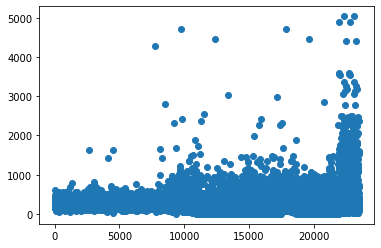

In [38]:
import matplotlib.pyplot as plt

plt.scatter(indexes, fake['length'])
plt.show()

Под конец были длинные тексты, но так как я убрала стоп-слова, они уже не 8к, а 5к. Среднее тоже подвинулось, квантили тоже сместились.
Если бы мы классфицировали на фейк и не фейк, там было бы принципиально соотношение обращений. Здесь все фейк, так что все стопы можно стереть, я думаю.

Давайте паддить до квантиля 0.75 (520) #upd в графике хорошо бы добавить измерение теплоты чтобы было  понятнее где основная масса наблюдений

upd: 0.9 после убирания стоп слов 408, будем паддить до нее, т.к. максимум 5к все же слишком много. а 408 еще и меньше +- стандартных 512

In [17]:
t = '''Government News    1570
Middle-east        778 
News               9050
US_News            783 
left-news          4459
politics           6838'''.splitlines()

lab = dict()
nums = Counter()
for line in t:
    sub, num = re.split('  +', line)
    nums[sub] = num

for num, (k,v) in enumerate(nums.most_common()):
    lab[k] = num + 1

lab

{'Government News': 6,
 'Middle-east': 3,
 'News': 1,
 'US_News': 2,
 'left-news': 5,
 'politics': 4}

In [18]:
fake['label'] = fake['subject'].apply(lambda x: lab[x])

### article

* C-LSTM

CNN: extract a sequence of higher-level phrase representations -> LSTM to
obtain the sentence representation

CNN - capturing local correlations of spatial or temporal structures

can learn short and long-range relations through pooling operations


RNN – is able to handle sequences of any length
and capture long-term dependencies

1) one-layer CNN output
1.1) pre-trained word vectors from massive unlabeled text data to learn higher-level representions of n-grams.
1.2) Then to learn sequential correlations from higher-level suqence representations, **the feature maps of CNN are organized as sequential window
features** to serve as the input of LSTM
2) to lstm

transform each each sentence to n-gram

eval: sentiment, 6-way question classification


* feature map
* window feature sequence layer corresponds to features for the same window
* The dashed lines connect the feature of a window with the source feature map
* The final output of the entire model is the last hidden unit of LSTM

1) one-dimensional convolution involves a filter
vector sliding over a sequence and detecting features at different positions

2) For each position
j in the sentence, we have a window vector wj with
k consecutive word vectors

3) filter m convolves with the window vectors
(k-grams) at each position in a valid way to generate a feature map c ∈ R
L−k+1; each element cj of
the feature map for window vector wj is produced
as follows:
cj = f(wj ◦ m + b), 
◦ is element-wise multiplication, b ∈ R is a
bias term and f is a nonlinear transformation function that can be sigmoid, hyperbolic tangent, etc. In
our case, we choose ReLU 

4) feature maps can be rearranged as feature representations for each window wj ,
W = [c1; c2; · · · ; cn
______________________
5) 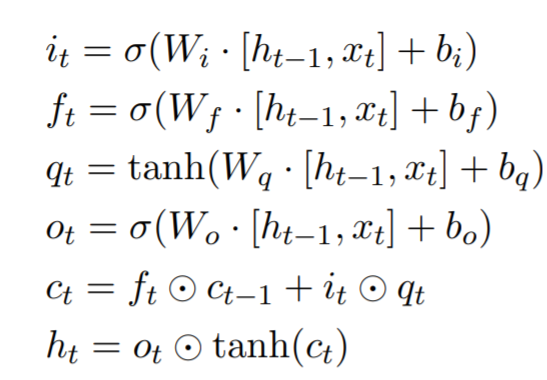

6) For text classification, we regard the output of the
hidden state at the last time step of LSTM as the
document representation and we add a softmax layer
on top.


7) minimizing
the cross-entropy error

8) stochastic gradient descent (SGD) to learn the model
parameters and adopt the optimizer RMSprop

9) PADDING - maxlen

10) word2vec, 300, UNK: [-0.25, 0.25]

regularization:

11) dropout (before feeding / before putting to lstm before softmax)

12) l2 weight reg to softmax

experiments:

Ex1: sentiment polar movie reviews Ex2: questions

5.2 For text preprocessing, we only
convert all characters in the dataset to lower case. >> BAD FOR FAKE NEWS  


(number of
filters: 150 / 300
 
filter length in CNN: 2,3,4
 
memory dimension in
LSTM: 150 / 300
 
dropout rate: 0.5
 
l2: 0.001  to the weights in the softmax
layer for both tasks

### practice

3) реализуйте на pytorch ту архитектуру модели, которую в итоге тестировали авторы (подробное описание есть в статье), таким образом, чтобы это был пайплайн для проведения экспериментов: можно было запускать модель с:


* maxlen
* reg type RMSprop, 0.001
* reg place: -> softmax
* padding
* vectorization
* number of filters: 150 / 300
* filter length in CNN: 2,3,4
* memory dimension: 150/300
* dropout 0.5, before feeding / before softmax

In [19]:
corpus_toks = []
for sublist in fake['tokens']:
    corpus_toks += sublist

corpus_toks = Counter(corpus_toks)

word2id = {'PAD':0, 'UNK':1}
c = 0
for k, length in corpus_toks.most_common():
  c += 1
  if length > 3:
    word2id[k] = c

len(word2id)

41314

In [20]:
id2word = {i:word for word, i in word2id.items()}

In [21]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM # https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:13<00:00, 127MB/s]


In [23]:
w2v = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [24]:
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.uniform(-0.25, 0.25, 300)
      # oov с-0.25:0:25
      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [66]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, maxlen, DEVICE):
        self.dataset = dataset['tokens'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['label'].values
        self.maxlen = maxlen
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index] # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id][:self.maxlen])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      #padded_ids = torch.stack([F.pad(id_, (0, self.maxlen - len(id_))) for id_ in ids], dim=0)
      #padded_ids = torch.vstack([F.pad(seq, pad=(0, self.maxlen - seq.shape[0])) for seq in ids])
      #padded_ids = pad_sequence(padded_ids, batch_first=True).to(self.device)
      padded_ids = torch.vstack([F.pad(idx, pad=(0, self.maxlen - idx.shape[0])) for idx in ids])
      padded_ids = pad_sequence(ids).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [67]:
maxlen = 408

train_data, val_data = train_test_split(fake[['tokens', 'label']], test_size=0.2, stratify=fake['label'], random_state=42)

train_dataset = NewsDataset(train_data, word2id, maxlen, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = NewsDataset(val_data, word2id, maxlen, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=train_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

* maxlen
* reg type RMSprop, 0.001
* reg place: -> softmax 
* vectorization
* number of filters: 150 / 300
* filter length in CNN: 2,3,4
* memory dimension: 150/300
* dropout 0.5, before feeding / before softmax

In [59]:
class CLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden, weights, maxlen, dropout, drop_time, filt_num, filt_len:list, mem_dim, class_n):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #300
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.hidden = hidden # 150

        self.maxlen = maxlen
        self.dropout = nn.Dropout(p=dropout)
        self.drop_time = drop_time

        self.filt_num = filt_num
        self.filt_len = filt_len
        self.mem_dim = mem_dim

        self.cnn2 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden, kernel_size=(2,))
        self.cnn3 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden, kernel_size=(3,))
        self.cnn4 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden, kernel_size=(4,))

        self.lstm = nn.LSTM(input_size=self.filt_num*len(self.filt_len), hidden_size=self.mem_dim, num_layers=1, batch_first=True)

        self.relu = nn.ReLU()
        self.out = nn.Softmax()
        self.linear = nn.Linear(hidden, class_n)

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        if self.drop_time == 0:
            embedded = self.dropout(embedded)
        
        f_maps = []
        if 2 in self.filt_len:
            feature_map = self.relu(self.cnn2(embedded))
            f_maps.append(feature_map)
        elif 3 in self.filt_len:
            feature_map = self.relu(self.cnn3(embedded))
            f_maps.append(feature_map)
        elif 4 in self.filt_len:
            feature_map = self.relu(self.cnn3(embedded))
            f_maps.append(feature_map)

        if len(f_maps) > 1:
            layers = [layer.transpose(1,2) for layer in f_maps]
            l_in = f_maps[0].transpose(1,2)
            for layer in layers[1:]:
                l_in = torch.cat((l_in, layer), 2)
        else:
            l_in = f_maps[0].transpose(1,2)

        
        outout, (hidden, _) = self.lstm(l_in)

        if self.drop_time == 1:
            logits = self.dropout(hidden)  
        logits = self.linear(hidden)
        logits = self.out(logits)
        return logits

In [29]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    epoch_loss = 0
    epoch_metric = 0

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds_proba = model(texts) #прогоняем данные через модель
        loss = criterion(preds_proba, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        batch_metric = f1(preds_proba.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric

        if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [30]:
def evaluate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            predictions = model(texts)  # делаем предсказания на тесте
            loss = criterion(predictions, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(predictions.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
  
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем средний лосс по батчам

In [72]:
vocab_size = len(word2id)
embedding_dim = 300
hidden = 150
maxlen = 408
dropout = 0.5
drop_time = [0, 1]
filt_num = 150
filt_len = [[2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]]
mem_dim = 150
class_n = 6

params_dict = {}

for f in filt_len:
    for d_time in drop_time:

        params = f'{f} {d_time}'
        print('Params:', params)

        model = CLSTM(vocab_size, embedding_dim, hidden, weights, maxlen, dropout, d_time, filt_num, f, mem_dim, class_n)
        optimizer = optim.RMSprop(model.parameters(), 0.001, 0.0001)
        criterion = nn.CrossEntropyLoss()

        # веса модели и значения лосса храним там же, где и все остальные тензоры
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)

        losses = []
        losses_eval = []

        for i in range(5):
            print(f'\nstarting Epoch {i}')
            epoch_loss = train(model, train_iterator, optimizer, criterion)
            losses.append(epoch_loss)

            epoch_loss_on_test = evaluate(model, val_iterator, criterion)
            losses_eval.append(epoch_loss_on_test)

        params_dict[params] = {'losses':losses,
                               'losses_eval': losses_eval}

Params: [2] 0

starting Epoch 0
Training...


RuntimeError: ignored